##### Importing libraries and framework

In [2]:
# Import the necessary libraries
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt
import pandas as pd

#### Prepare the data  (able to reuse the code from linear_regression.ipynb)

In [3]:
# Load the data from the CSV file into a DataFrame
data = pd.read_csv('datasets/listings_preprocessed.csv')

# Separate the input features (X) and target variable (y)
X = data.drop('price', axis=1)
y = data['price']

# Filter out non-numeric columns
numeric_columns = X.select_dtypes(include=['number']).columns
X_numeric = X[numeric_columns]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_numeric, y, test_size=0.2, random_state=42)

# One-hot encode categorical features
X_train = pd.get_dummies(X_train)
X_test = pd.get_dummies(X_test)

# Align the columns of the training and testing sets
X_train, X_test = X_train.align(X_test, join='left', axis=1)

# Fill missing values in the training set with the mean of each column
X_train.fillna(X_train.mean(), inplace=True)

# Fill missing values in the test set with the mean of the corresponding columns in the training set
X_test.fillna(X_train.mean(), inplace=True)

# Fill remaining NaN values with 0
X_train.fillna(0, inplace=True)
X_test.fillna(0, inplace=True)

#### Filter and extract only top 5 variables to be used to predict the price (able to reuse the code from linear_regression.ipynb)

In [4]:
def select_top_k_abs_correlated(X_train, y_train, X_test, k):
    # Calculate the correlation matrix between features and the target variable
    corr_matrix = X_train.corrwith(y_train)

    # Compute the absolute correlation values
    abs_corr_matrix = corr_matrix.abs()

    # Select the top k variables with the highest absolute correlation values
    top_k_abs_correlated = abs_corr_matrix.sort_values(ascending=False)[:k]

    # Print the top k variables
    print(f"Top {k} variables with the highest absolute correlation values:\n", top_k_abs_correlated)

    # Filter the original training and testing sets to include only the top k variables with the highest absolute correlation values
    X_train_selected = X_train[top_k_abs_correlated.index]
    X_test_selected = X_test[top_k_abs_correlated.index]

    return X_train_selected, X_test_selected, top_k_abs_correlated

X_train_selected, X_test_selected, top_k_abs_correlated = select_top_k_abs_correlated(X_train, y_train, X_test, k=5)

Top 5 variables with the highest absolute correlation values:
 room_type_Private room                         0.442091
bedrooms                                       0.425693
calculated_host_listings_count_entire_homes    0.410485
property_type_Private room in rental unit      0.400065
minimum_nights                                 0.389756
dtype: float64


#### Create the model and predict the data

#### Display the performance metrics

In [12]:
def train_and_evaluate_decision_tree(X_train, y_train, X_test, y_test):
    # Create a decision tree regression model
    model = DecisionTreeRegressor(random_state=42)

    # Train the model using the training data with the selected features
    model.fit(X_train, y_train)

    # Predict the prices for the test set
    y_pred = model.predict(X_test)

    # Calculate the mean squared error and R^2 score for the predictions
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    # Print the results
    print("Performance metrics")
    print("Mean squared error:", mse)
    print("R^2 score:", r2)

    return model, mse, r2, y_pred


model, mse, r2, y_pred = train_and_evaluate_decision_tree(X_train_selected, y_train, X_test_selected, y_test)

Performance metrics
Mean squared error: 6936.384671877559
R^2 score: 0.5792408815427761


#### Decision tree models do not have coefficients like linear regression models. Decision trees use a tree-like structure to make decisions based on feature values rather than using coefficients to represent the relationship between the features and the target variable.

#### However, I can obtain the feature importances from a decision tree model, which represent how important each feature is for making predictions. The higher the importance, the more the feature contributes to the model's decision-making process. Here's how you can obtain and print the feature importances:

In [9]:
# Extract the feature importances from the trained model
feature_importances = model.feature_importances_

def print_sorted_feature_importances(feature_names, feature_importances):
    # Pair feature names with their importances and sort in descending order
    sorted_importances = sorted(zip(feature_names, feature_importances), key=lambda x: x[1], reverse=True)

    # Print the sorted feature importances
    print("Feature importance")
    for feature, importance in sorted_importances:
        print(f"{feature}: {importance:.4f}")


print_sorted_feature_importances(top_k_abs_correlated, feature_importances)

Feature importance
0.41048452219713794: 0.5444
0.389756167687764: 0.2012
0.42569278999593996: 0.1874
0.4420911016284186: 0.0444
0.40006513672477356: 0.0226


#### To visualize the performance of the decision tree model, you can create a scatter plot of the true prices (y_test) against the predicted prices (y_pred), similar to the linear regression model:

#### Plot the decision tree model

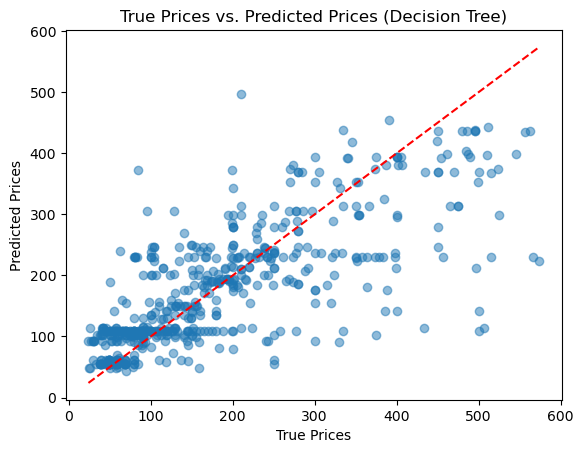

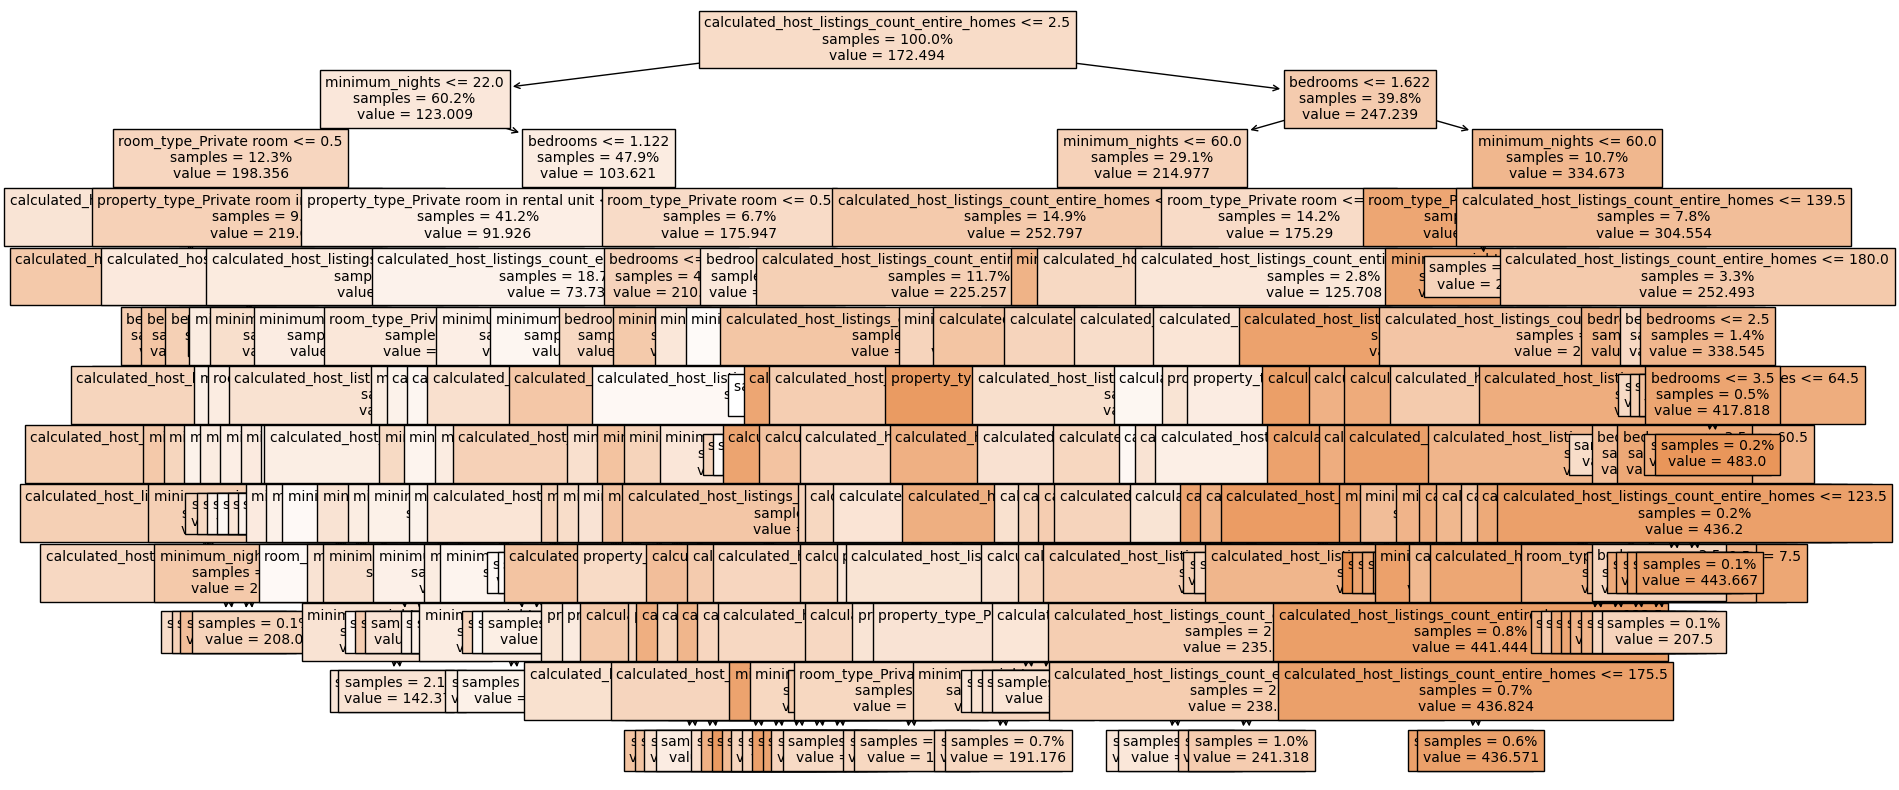

In [13]:
def plot_decision_tree(y_test, y_pred, model, feature_names):
    # Create a scatter plot of the true prices against the predicted prices
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.xlabel('True Prices')
    plt.ylabel('Predicted Prices')
    plt.title('True Prices vs. Predicted Prices (Decision Tree)')

    # Add a diagonal line to represent perfect predictions
    min_val = min(y_test.min(), y_pred.min())
    max_val = max(y_test.max(), y_pred.max())
    plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--')

    # Show the plot
    plt.show()

    # Set up the figure and axis
    fig, ax = plt.subplots(figsize=(20, 10))

    # Plot the decision tree
    plot_tree(model, ax=ax, feature_names=feature_names, filled=True, fontsize=10, impurity=False, proportion=True)

    # Show the plot
    plt.show()


plot_decision_tree(y_test, y_pred, model, top_k_abs_correlated.index)

#### As there are many variables to compare along, we have concluded that decision tree regression is not a suitable model.

#### Solution: We reduce the depth limit so that it is more presentable even though it might not be accurate

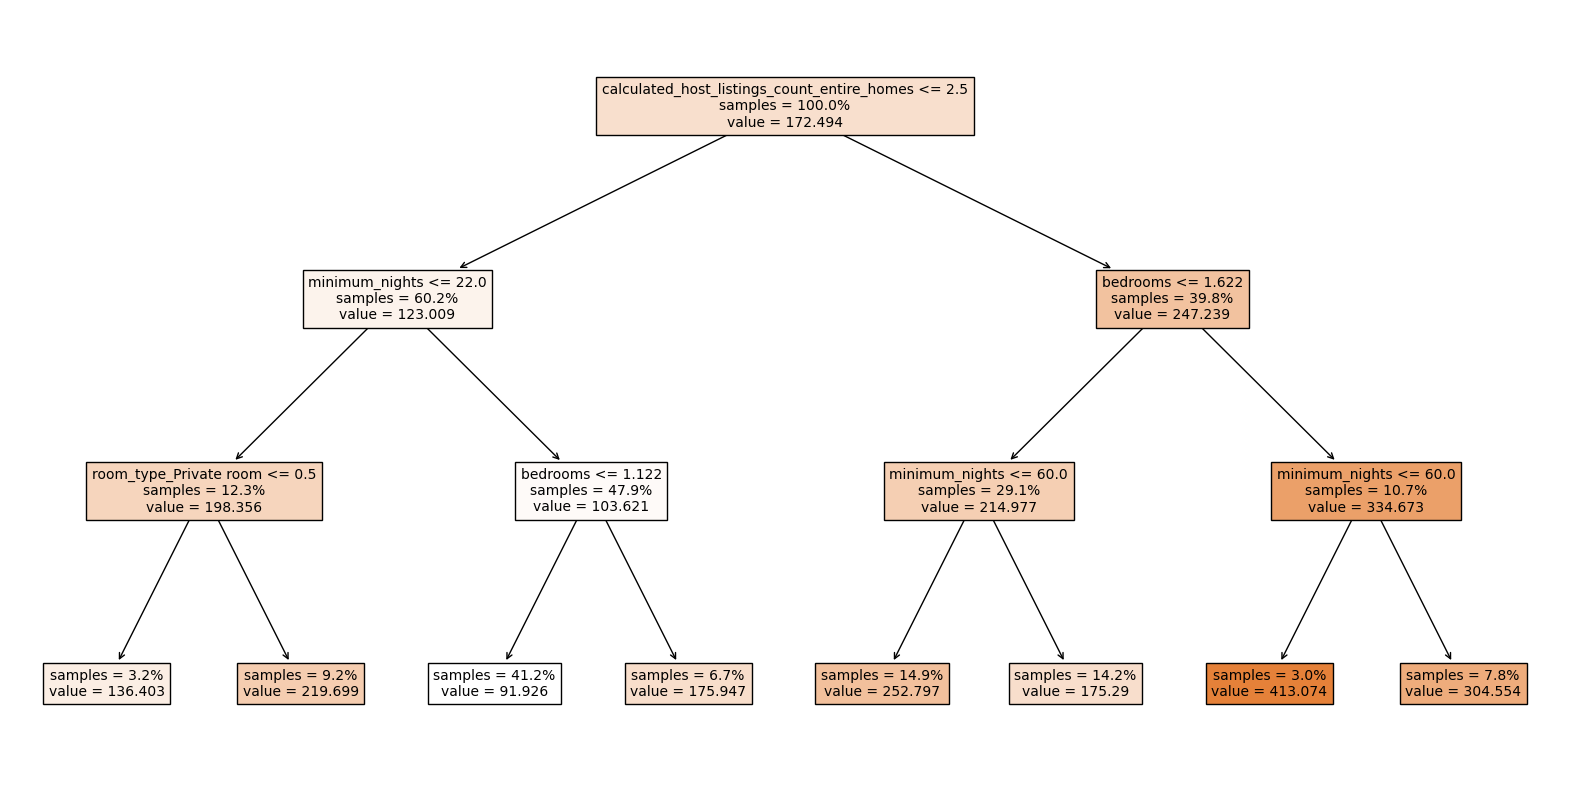

In [14]:
def train_and_plot_decision_tree(X_train_selected, y_train, feature_names, max_depth=3, random_state=42):
    # Create a decision tree regression model with a limited depth
    model = DecisionTreeRegressor(max_depth=max_depth, random_state=random_state)

    # Train the model using the training data with the selected features
    model.fit(X_train_selected, y_train)

    # Set up the figure and axis
    fig, ax = plt.subplots(figsize=(20, 10))

    # Plot the decision tree
    plot_tree(model, ax=ax, feature_names=feature_names, filled=True, fontsize=10, impurity=False, proportion=True)

    # Show the plot
    plt.show()
    
    return model

trained_model = train_and_plot_decision_tree(X_train_selected, y_train, top_k_abs_correlated.index, max_depth=3, random_state=42)

#### 

#### Decision tree regression can handle both numerical and categorical data, so the variables with higher correlation coefficients as well as categorical variables can be used to build a decision tree regression model.